# HDB Flat Resale Price Predictor

Project Goal: Predict HDB flat resale prices based on flat features (e.g. flat type, floor area), using machine learning models for supervised regression.

# Exploratory Data Analysis

Data Source: https://data.gov.sg/datasets/d_8b84c4ee58e3cfc0ece0d773c8ca6abc/view (Resale flat prices based on registration date from Jan-2017 onwards)

The dataset contains 207445 data samples from Jan 2017 to May 2025. The data samples do not contain any null values.

Features of Raw Data:

1.   month: Month of registration of HDB flat resale transaction
2.   town: Town of HDB flat (e.g. ANG MO KIO)
1.   flat_type: Flat type of HDB flat (e.g. 3 ROOM)
2.   block: Block of HDB flat
1.   street_name: Street name of HDB flat
2.   storey_range: Storey range of HDB flat (e.g. 10 TO 12)
1.   floor_area_sqm: Floor area of HDB flat in square meters
2.   flat_model: Flat model of HDB flat (e.g. New Generation)
1.   lease_commence_date: Year of lease commencement of HDB flat
2.   remaining_lease: Remaining lease of HDB flat in years and months
1.   resale_price: Resale price of HDB flat in S$



In [ ]:
#import libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor, XGBRFRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import root_mean_squared_error, r2_score

import joblib

In [ ]:
#load dataset
df = pd.read_csv('ResaleflatpricesbasedonregistrationdatefromJan2017onwards.csv')

#show raw data information
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207445 entries, 0 to 207444
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   month                207445 non-null  object 
 1   town                 207445 non-null  object 
 2   flat_type            207445 non-null  object 
 3   block                207445 non-null  object 
 4   street_name          207445 non-null  object 
 5   storey_range         207445 non-null  object 
 6   floor_area_sqm       207445 non-null  float64
 7   flat_model           207445 non-null  object 
 8   lease_commence_date  207445 non-null  int64  
 9   remaining_lease      207445 non-null  object 
 10  resale_price         207445 non-null  float64
dtypes: float64(2), int64(1), object(8)
memory usage: 17.4+ MB


,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
0,2017-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61 years 04 months,232000.0
1,2017-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,60 years 07 months,250000.0
2,2017-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,262000.0
3,2017-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,62 years 01 month,265000.0
4,2017-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,265000.0


In [ ]:
#show categories in categorical data
categorical_features = ['town', 'flat_type', 'storey_range', 'flat_model']
for feature in categorical_features:
    print(f"\nUnique values in '{feature}' column:")
    print(pd.Series(df[feature].unique()).sort_values().tolist())


Unique values in 'town' column:
['ANG MO KIO', 'BEDOK', 'BISHAN', 'BUKIT BATOK', 'BUKIT MERAH', 'BUKIT PANJANG', 'BUKIT TIMAH', 'CENTRAL AREA', 'CHOA CHU KANG', 'CLEMENTI', 'GEYLANG', 'HOUGANG', 'JURONG EAST', 'JURONG WEST', 'KALLANG/WHAMPOA', 'MARINE PARADE', 'PASIR RIS', 'PUNGGOL', 'QUEENSTOWN', 'SEMBAWANG', 'SENGKANG', 'SERANGOON', 'TAMPINES', 'TOA PAYOH', 'WOODLANDS', 'YISHUN']

Unique values in 'flat_type' column:
['1 ROOM', '2 ROOM', '3 ROOM', '4 ROOM', '5 ROOM', 'EXECUTIVE', 'MULTI-GENERATION']

Unique values in 'storey_range' column:
['01 TO 03', '04 TO 06', '07 TO 09', '10 TO 12', '13 TO 15', '16 TO 18', '19 TO 21', '22 TO 24', '25 TO 27', '28 TO 30', '31 TO 33', '34 TO 36', '37 TO 39', '40 TO 42', '43 TO 45', '46 TO 48', '49 TO 51']

Unique values in 'flat_model' column:
['2-room', '3Gen', 'Adjoined flat', 'Apartment', 'DBSS', 'Improved', 'Improved-Maisonette', 'Maisonette', 'Model A', 'Model A-Maisonette', 'Model A2', 'Multi Generation', 'New Generation', 'Premium Apartment

In [ ]:
#show no. unique values in categorical data
count = df['street_name'].nunique()
print(f"Number of unique values in 'street_name' column: {count}")

Number of unique values in 'street_name' column: 574


**Data Visualisation**

**Mean Resale Price by Month (Line Plot):** Mean resale price by month has generally increased by around $200,000 over a period of 8 years, although there was a slight dip and stagnation from the middle of 2018 to the end of 2019.

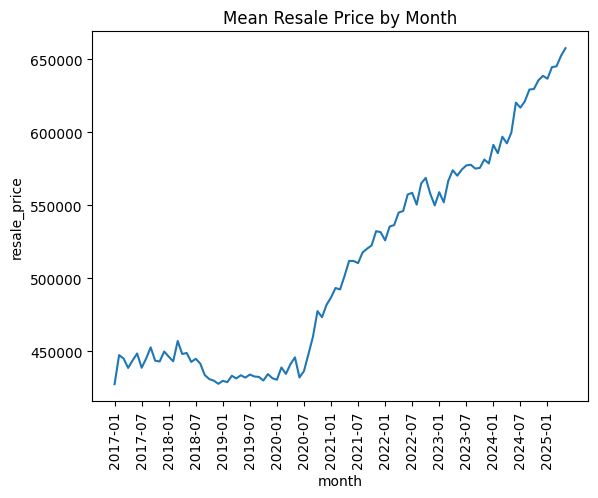

In [ ]:
monthly_mean = df.groupby('month')['resale_price'].mean().reset_index()
sns.lineplot(x='month', y='resale_price', data=monthly_mean)
plt.xticks(monthly_mean['month'][::6], rotation=90)
plt.title('Mean Resale Price by Month')
plt.show()

**Resale Price by Town (Box Plot):** The largest difference in median resale price by town is almost $400,000. There are many high resale price outliers in almost all of the towns.

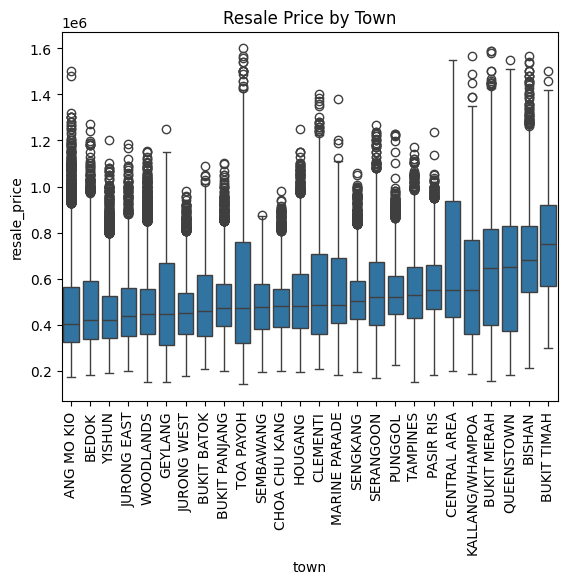

In [ ]:
sns.boxplot(x='town', y='resale_price', data=df, order=df.groupby('town')['resale_price'].median().sort_values().index)
plt.xticks(rotation=90)
plt.title('Resale Price by Town')
plt.show()

**Resale Price by Flat Type (Box Plot):** The largest difference in median resale price by flat type is more than $600,000. There are many high resale price outliers for the 3 ROOM, 4 ROOM, 5 ROOM, and EXECUTIVE HDB flats.

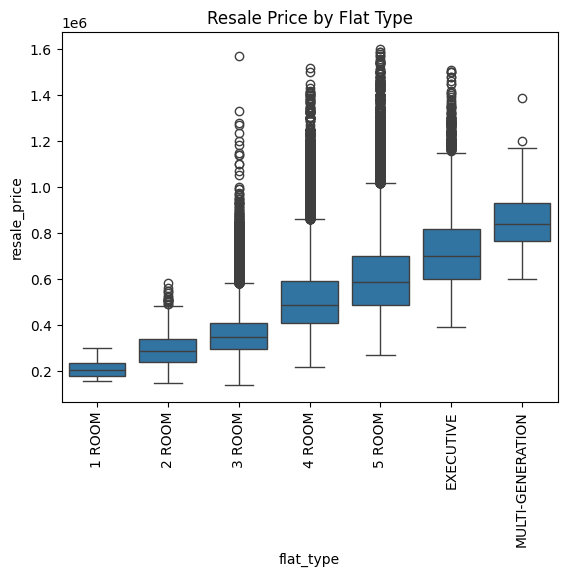

In [ ]:
sns.boxplot(x='flat_type', y='resale_price', data=df, order=df.groupby('flat_type')['resale_price'].median().sort_values().index)
plt.xticks(rotation=90)
plt.title('Resale Price by Flat Type')
plt.show()

**Resale Price by Flat Model (Box Plot):** The largest difference in median resale price by flat model is almost $800,000. Some of the flat models with relatively low median values (e.g. Improved, Apartment) have many high resale price outliers comparable to the resale prices of the flat models with high median values.

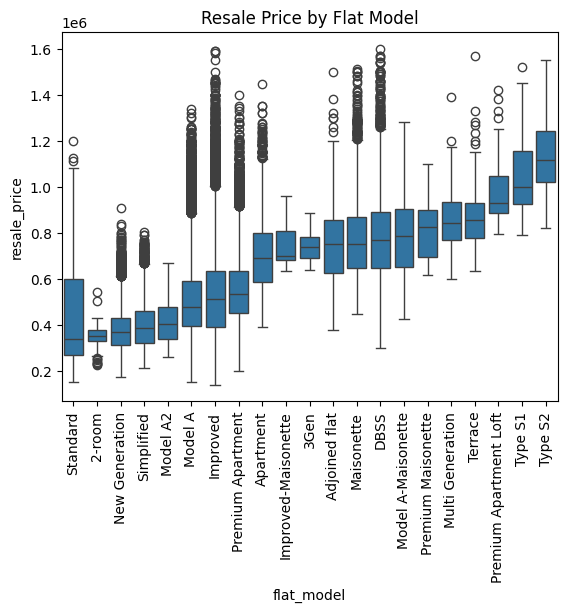

In [ ]:
sns.boxplot(x='flat_model', y='resale_price', data=df, order=df.groupby('flat_model')['resale_price'].median().sort_values().index)
plt.xticks(rotation=90)
plt.title('Resale Price by Flat Model')
plt.show()

**Initial Data Preprocessing**

**Feature Engineering:**

1.   storey_range_mean: Mean of storey range of HDB flat

  Converted storey_range to its mean value (e.g. 10 TO 12 --> 11.0) to transform categorical range data into a numerical format that preserves its inherent ordinal nature and allows for quantitative analysis.
2.   remaining_lease_years: Remaining lease of HDB flat in years

  Converted remaining_lease to a decimal value (e.g. 61 years 04 months --> 61.333333) to represent remaining lease duration as a continuous numerical variable that allows for quantitative analysis.

In [ ]:
#convert storey_range to mean value
df['storey_range_mean'] = df['storey_range'].str.split(' TO ').apply(lambda x: (int(x[0]) + int(x[1])) / 2)

#convert remaining lease to decimal value
def remaining_lease_to_years(lease_str):
    match = re.match(r"(\d+)\s+years\s*(\d+)?", lease_str)
    if match:
        years = int(match.group(1))
        months = int(match.group(2)) if match.group(2) else 0
        return years + months / 12
    return None

df['remaining_lease_years'] = df['remaining_lease'].apply(remaining_lease_to_years)

**Data Visualisation (Continued)**

**Resale Price by Mean Storey Range (Box Plot):** The largest difference in median resale price by mean storey range is almost $800,000. Median resale price increases as the mean storey range increases. There are many high resale price outliers for flats with low mean storey range (e.g. 2.0, 8.0), and there are also some low resale price outliers for flats with high mean storey range (e.g. 29.0, 41.0).

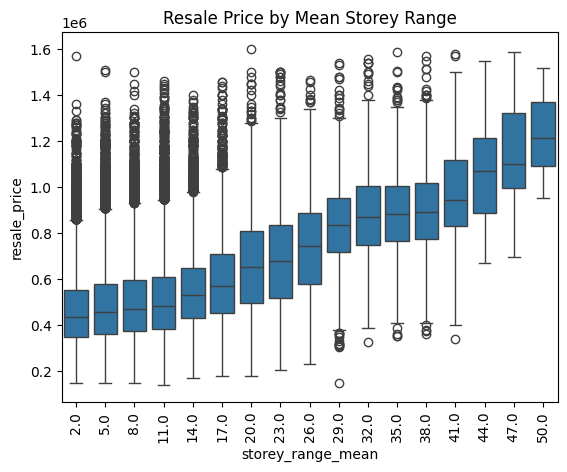

In [ ]:
sns.boxplot(x='storey_range_mean', y='resale_price', data=df, order=df.groupby('storey_range_mean')['resale_price'].median().sort_values().index)
plt.xticks(rotation=90)
plt.title('Resale Price by Mean Storey Range')
plt.show()

In [ ]:
#show outlier data sample
storey_29 = df[df['storey_range_mean'] == 29.0]
print(df.iloc[storey_29['resale_price'].idxmin()])

month                               2023-12
town                              WOODLANDS
flat_type                            2 ROOM
block                                  182A
street_name                 WOODLANDS ST 13
storey_range                       28 TO 30
floor_area_sqm                         47.0
flat_model                          Model A
lease_commence_date                    2019
remaining_lease          94 years 11 months
resale_price                       150000.0
storey_range_mean                      29.0
remaining_lease_years             94.916667
Name: 167184, dtype: object


**Resale Price by Remaining Lease Years (Scatter Plot with Regression Line):** Resale price increases as the number of remaining lease years increases.

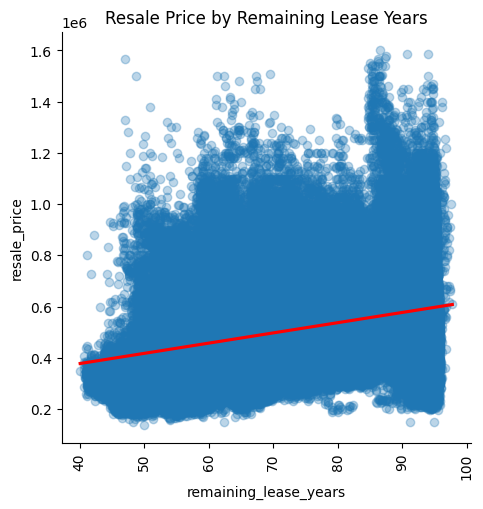

In [ ]:
sns.lmplot(x='remaining_lease_years', y='resale_price', data=df, scatter_kws={'alpha':0.3}, line_kws={"color": "red"})
plt.xticks(rotation=90)
plt.title('Resale Price by Remaining Lease Years')
plt.show()

**Resale Price by Remaining Lease Years (Binned Box Plot):** The largest difference in median resale price by remaining lease years is slightly under $300,000. There are many high resale price outliers even for flats with fewer remaining lease years (e.g. 45.85-51.617).

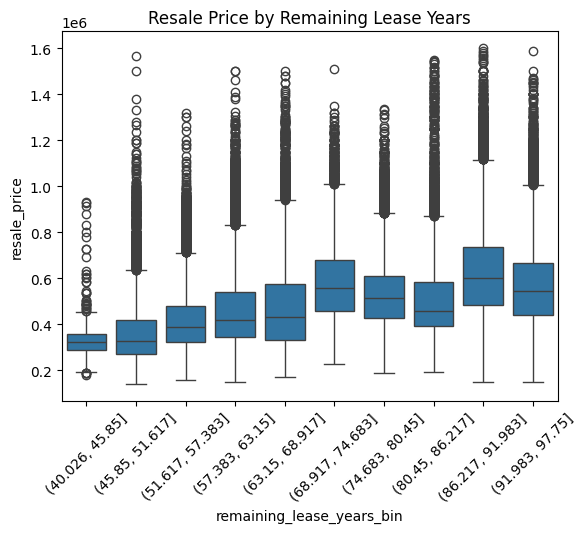

In [ ]:
df['remaining_lease_years_bin'] = pd.cut(df['remaining_lease_years'], bins=10)
sns.boxplot(x='remaining_lease_years_bin', y='resale_price', data=df)
plt.xticks(rotation=45)
plt.title('Resale Price by Remaining Lease Years')
plt.show()

**Resale Price by Floor Area Sqm (Scatter Plot with Regression Line):** Resale price increases as floor area (sqm) increases.

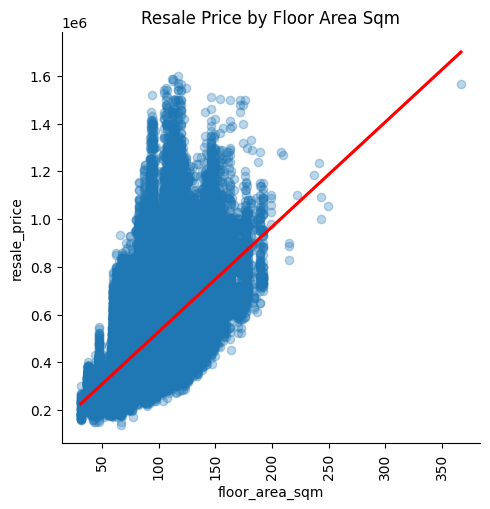

In [ ]:
sns.lmplot(x='floor_area_sqm', y='resale_price', data=df, scatter_kws={'alpha':0.3}, line_kws={"color": "red"})
plt.xticks(rotation=90)
plt.title('Resale Price by Floor Area Sqm')
plt.show()

In [ ]:
#show outlier data sample
print(df.iloc[df['floor_area_sqm'].idxmax()])

month                        2024-07-01 00:00:00
town                             KALLANG/WHAMPOA
flat_type                                 3 ROOM
block                                         53
street_name                           JLN MA'MOR
storey_range                            01 TO 03
floor_area_sqm                             366.7
flat_model                               Terrace
lease_commence_date                         1972
remaining_lease                         47 years
resale_price                           1568000.0
storey_range_mean                            2.0
remaining_lease_years                       47.0
remaining_lease_years_bin        (45.85, 51.617]
floor_area_sqm_bin               (333.13, 366.7]
Name: 181463, dtype: object


**Resale Price by Floor Area Sqm (Binned Box Plot):** Excluding the single outlier, the largest difference in median resale price by floor area (sqm) is almost $800,000. There are many high resale price outliers even for flats with smaller floor area (sqm) (e.g. 64.57-98.14).

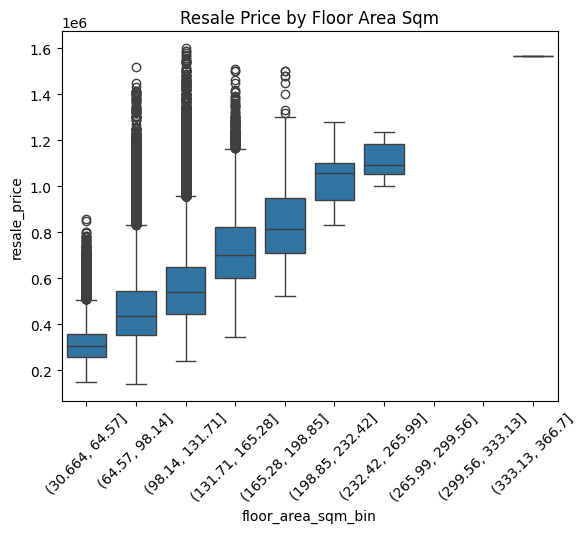

In [ ]:
df['floor_area_sqm_bin'] = pd.cut(df['floor_area_sqm'], bins=10)
sns.boxplot(x='floor_area_sqm_bin', y='resale_price', data=df)
plt.xticks(rotation=45)
plt.title('Resale Price by Floor Area Sqm')
plt.show()

**Distribution of Each Feature (Histogram Plot):** The distribution of all features are not even.

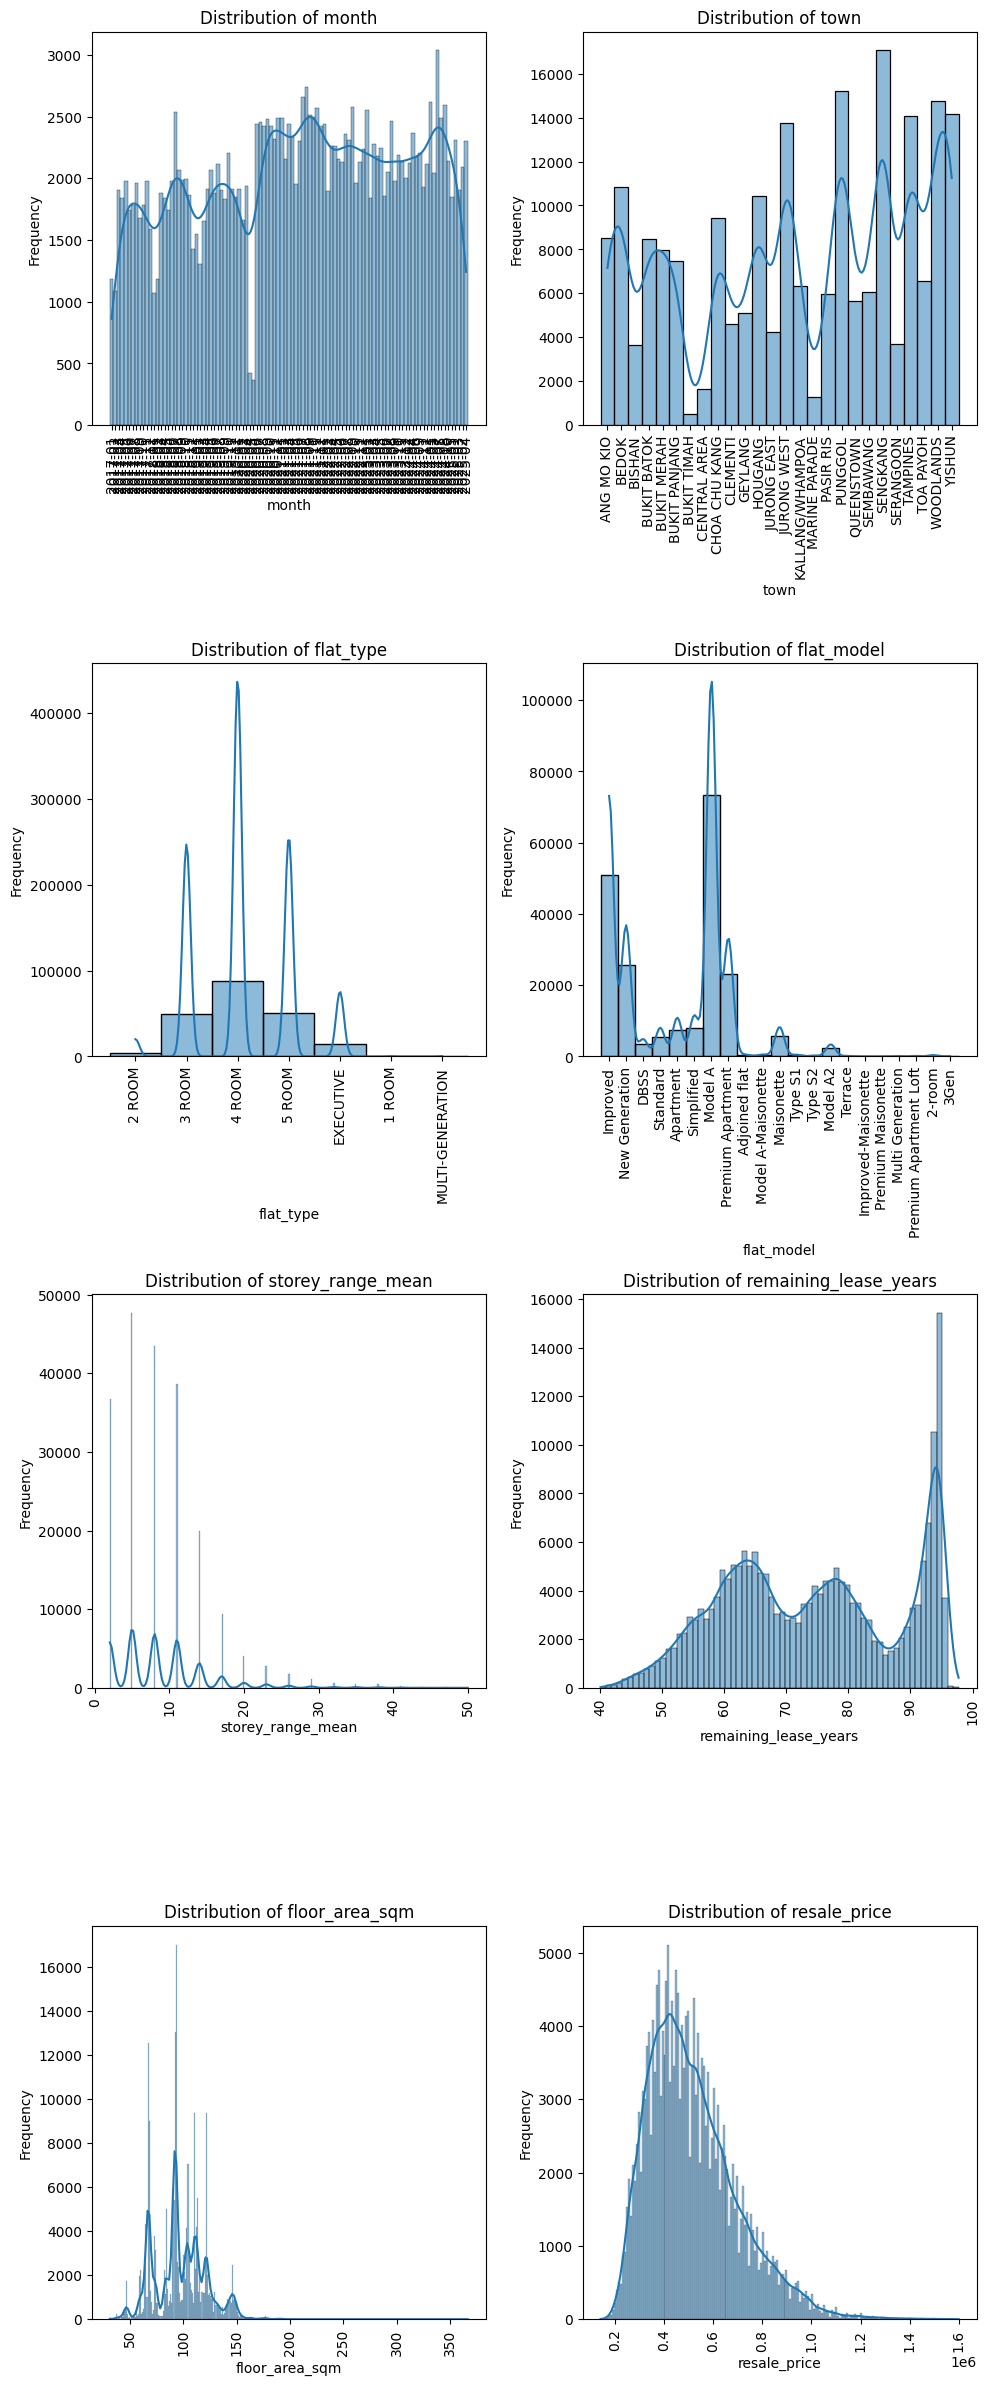

In [ ]:
selected_features = ['month', 'town', 'flat_type', 'flat_model', 'storey_range_mean', 'remaining_lease_years', 'floor_area_sqm', 'resale_price']

plt.figure(figsize=(10, 24))

for i, feature in enumerate(selected_features):
    plt.subplot(4, 2, i + 1)
    sns.histplot(df[feature], kde=True)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.xticks(rotation=90)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Data Preprocessing

**Feature Engineering:**

1.   storey_range_mean: Mean of storey range of HDB flat

  Converted 'storey_range' to its mean value (e.g. 10 TO 12 --> 11.0) to transform categorical range data into a numerical format that preserves its inherent ordinal nature and allows for quantitative analysis.
2.   remaining_lease_years: Remaining lease of HDB flat in years

  Converted 'remaining_lease' to a decimal value (e.g. 61 years 04 months --> 61.333333) to represent remaining lease duration as a continuous numerical variable that allows for quantitative analysis.
1.   year: Year of registration of HDB flat resale transaction

  Extracted the year from 'month' to obtain a numerical variable that allows for quantitative analysis.



**Feature Selection:** Dropped 'block' and 'street_name' as they are categorical features with high cardinality (e.g. 'street_name' has 574 unique values), and the location information that they provide can be largely captured by 'town'.

**Data Splitting:** Split the data into training and test sets for model training and evaluation. Further split the training data into training and validation sets for manual hyperparameter tuning.

**Feature Scaling:** Scaled numerical features to standardise the data, such that each numerical feature's mean is 0 and standard deviation is 1.


**Feature Encoding:** Converted categorical features into binary (0/1) columns (one-hot encoding), so that the categorical data can be processed.

In [ ]:
#extract year as a feature
df['year'] = df['month'].str.split('-').apply(lambda x: int(x[0]))

In [ ]:
#feature selection
x = df.drop(['month', 'block', 'street_name', 'storey_range', 'lease_commence_date', 'remaining_lease', 'resale_price'], axis=1)
y = df['resale_price']

#check final features
x.info()
y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207445 entries, 0 to 207444
Data columns (total 7 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   town                   207445 non-null  object 
 1   flat_type              207445 non-null  object 
 2   floor_area_sqm         207445 non-null  float64
 3   flat_model             207445 non-null  object 
 4   storey_range_mean      207445 non-null  float64
 5   remaining_lease_years  207445 non-null  float64
 6   year                   207445 non-null  int64  
dtypes: float64(3), int64(1), object(3)
memory usage: 11.1+ MB
<class 'pandas.core.series.Series'>
RangeIndex: 207445 entries, 0 to 207444
Series name: resale_price
Non-Null Count   Dtype  
--------------   -----  
207445 non-null  float64
dtypes: float64(1)
memory usage: 1.6 MB


In [ ]:
#split data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [ ]:
#split training data into training and validation sets
x_train_sub, x_val, y_train_sub, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [ ]:
numerical_features = ['floor_area_sqm', 'storey_range_mean', 'remaining_lease_years', 'year']
categorical_features = ['town', 'flat_type', 'flat_model']

#scale numerical features
#encode categorical features
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

# Model Training, Tuning and Evaluation

Models:

*   **Multiple Linear Regression**
  
  Simple and fast baseline model that assumes a linear relationship between the independent features and the dependent feature.


*   **Decision Tree**

  Non-parametric model that recursively splits data into smaller subsets based on independent features and decision rules. Captures complex, non-linear patterns.

*   **XGBoost's Random Forest (Bagging)**

  Ensemble of multiple independent decision trees that are trained on random subsets of the training data and consider random subsets of the independent features for splitting. Reduces overfitting compared to a single decision tree.

*   **XGBoost (Boosting)**

  Optimised gradient boosting algorithm that builds decision trees sequentially, where each new tree corrects the errors of the previous ones. Tends to outperform random forest due to its learning mechanism and regularisation.

*   **k-Nearest Neighbours (KNN)**

  Non-parametric method that predicts the value of the dependent feature based on the average of the k nearest data points in the feature space. Inefficient on large datasets.

Evaluation Metrics:


*   **R² (R-squared)**

  R² represents the proportion of variance in the dependent variable that can be explained by the independent variable(s) in a regression model. R² values range from 0 to 1 (or 0% to 100%). An R² of 1 signifies a perfect fit, where the model explains all the variation in the dependent variable. An R² of 0 indicates that the model does not explain any of the variation in the dependent variable.
*   **RMSE (Root Mean Squared Error)**

  RMSE calculates the square root of the average of the squared differences between predicted and actual values. RMSE is expressed in the same units as the target variable, making it easier to understand the magnitude of the errors. A lower RMSE value indicates a better model fit, meaning the predictions are closer to the actual values.



**Preliminary Evaluation:** Training on full training set with default/basic hyperparameters, evaluating on test set

In [ ]:
#store models in a dictionary
models = {
    'Multiple Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(),
    "XGBoost's Random Forest": XGBRFRegressor(n_estimators=100, max_depth=20),
    'XGBoost': XGBRegressor(n_estimators=100, max_depth=20),
    'KNN': KNeighborsRegressor()
}

In [ ]:
#loop through models in dictionary
for name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])

    #train model on training set
    pipeline.fit(x_train, y_train)

    #evaluate model on test set
    y_pred = pipeline.predict(x_test)
    r2 = r2_score(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)
    print(f"{name} - R2: {r2:.4f}, RMSE: {rmse:.4f}")

XGBoost's Random Forest - R2: 0.9550, RMSE: 38593.6367


Results:

*   **Multiple Linear Regression**
  
  R²: 0.8643, RMSE: 67005.0556


*   **Decision Tree**

  R²: 0.9284, RMSE: 48676.5248

*   **XGBoost's Random Forest (Bagging)**

  (n_estimators=100, max_depth=20) - R²: 0.9381, RMSE: 45238.0681

*   **XGBoost (Boosting)**

  (n_estimators=100, max_depth=20) - R²: 0.9543, RMSE: 38883.3471

*   **k-Nearest Neighbours (KNN)**

  R²: 0.9473, RMSE: 41776.5657

XGBoost's Random Forest and XGBoost are the selected models for hyperparameter tuning as they are efficient and produce promising results.

**Manual Hyperparameter Tuning:** Training on subset of training set, evaluating on validation set

Hyperparameters:

*   n_estimators: Number of trees
*   max_depth: Maximum depth of a tree

In [ ]:
#store models in a dictionary
models = {
    # "XGBoost's Random Forest": XGBRFRegressor(n_estimators=150, max_depth=30),
    'XGBoost': XGBRegressor(n_estimators=200, max_depth=10)
}

In [ ]:
#loop through models in dictionary
for name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])

    #train model on subset of training set
    pipeline.fit(x_train_sub, y_train_sub)

    #evaluate model on validation set
    y_val_pred = pipeline.predict(x_val)
    r2 = r2_score(y_val, y_val_pred)
    rmse = root_mean_squared_error(y_val, y_val_pred)
    print(f"{name} - R2: {r2:.4f}, RMSE: {rmse:.4f}")

XGBoost - R2: 0.9594, RMSE: 36643.9099


Results:

*   **XGBoost's Random Forest (Bagging)**

  (n_estimators=100, max_depth=20) - R²: 0.9354, RMSE: 46235.7658

  (n_estimators=100, **max_depth=30**) - R²: 0.9518, RMSE: 39944.3697

  (n_estimators=100, max_depth=40) - R²: 0.9510, RMSE: 40263.4199

  (n_estimators=50, max_depth=30) - R²: 0.9515, RMSE: 40045.2463

  (**n_estimators=150**, max_depth=30) - R²: 0.9519, RMSE: 39908.2729

*   **XGBoost (Boosting)**

  (n_estimators=100, max_depth=20) - R²: 0.9506, RMSE: 40424.9598

  (n_estimators=100, max_depth=30) - R²: 0.9464, RMSE: 42099.9816

  (n_estimators=100, **max_depth=10**) - R²: 0.9585, RMSE: 37067.6027

  (n_estimators=150, max_depth=10) - R²: 0.9592, RMSE: 36728.7964

  (**n_estimators=200**, max_depth=10) - R²: 0.9594, RMSE: 36643.9099

XGBoost's Random Forest (n_estimators=150, max_depth=30) and XGBoost (n_estimators=200, max_depth=10) are the models that produce the best results on the validation set. They use different values for n_estimators and max_depth, which reflects the fundamental differences between bagging and boosting strategies:

* Bagging (XGBoost’s Random Forest) builds trees independently on random subsets of the data. Since each tree is trained in isolation and predictions are averaged, the model benefits from using deep trees (e.g., max_depth=30) that can capture complex patterns. A moderate number of trees (e.g., n_estimators=150) is usually sufficient, as adding more deep trees offers diminishing returns.

* Boosting (XGBoost), on the other hand, builds trees sequentially, where each tree learns from the residual errors of the previous ones. To avoid overfitting these residuals, boosting performs best with shallower trees (e.g., max_depth=10) that act as weak learners. It typically requires more trees (e.g., n_estimators=200) to gradually improve predictions while maintaining generalisation.

These hyperparameter choices highlight how bagging favours fewer, deeper trees, while boosting prefers more, shallower ones.

**Final Evaluation:** Training on full training set with best hyperparameters found, evaluating on test set

In [ ]:
#store models in a dictionary
models = {
    # "XGBoost's Random Forest": XGBRFRegressor(n_estimators=150, max_depth=30),
    'XGBoost': XGBRegressor(n_estimators=200, max_depth=10)
}

In [ ]:
#loop through models in dictionary
for name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])

    #train model on training set
    pipeline.fit(x_train, y_train)

    #evaluate model on test set
    y_pred = pipeline.predict(x_test)
    r2 = r2_score(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)
    print(f"{name} - R2: {r2:.4f}, RMSE: {rmse:.4f}")

XGBoost - R2: 0.9613, RMSE: 35787.8322


Results:

*   **XGBoost's Random Forest (Bagging)**

  (n_estimators=150, max_depth=30) - R²: 0.9550, RMSE: 38593.6367

*   **XGBoost (Boosting)**

  (n_estimators=200, max_depth=10) - R²: 0.9613, RMSE: 35787.8322


XGBoost (n_estimators=200, max_depth=10) is the model that produces the best results on the test set.

In [ ]:
#save pipeline for deployment
joblib.dump(pipeline, 'pipeline.pkl')

['pipeline.pkl']

**Data Visualisation**

**Predicted vs Actual Resale Price (Scatter Plot with Reference Line):** The majority of the data points lie close to the reference line (where Predicted Resale Price = Actual Resale Price), which shows that the model is able to make largely accurate predictions.

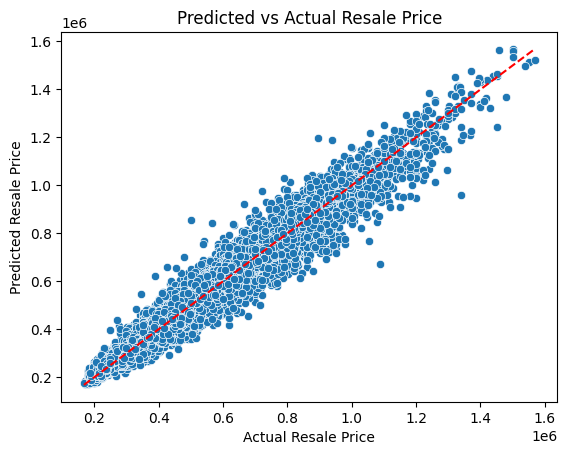

In [ ]:
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel('Actual Resale Price')
plt.ylabel('Predicted Resale Price')
plt.title('Predicted vs Actual Resale Price')
min_val = min(min(y_test), min(y_pred))
max_val = max(max(y_test), max(y_pred))
plt.plot([min_val, max_val], [min_val, max_val], 'r--')
plt.show()

**Distribution of Residuals (Histogram Plot):** The residuals follow a normal distribution centred at 0, which shows that the model is able to make largely accurate predictions.

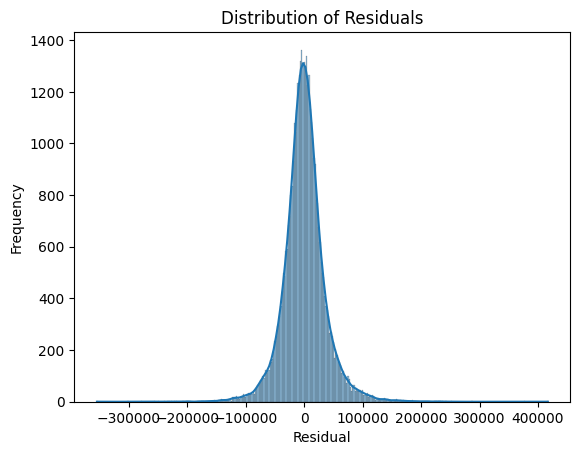

In [ ]:
residuals = y_test - y_pred
sns.histplot(residuals, kde=True)
plt.title("Distribution of Residuals")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.show()

# Model Deployment

Streamlit App: https://hdb-flat-resale-price-predictor-hr36dfqigzrdvqp2dgxjhg.streamlit.app/

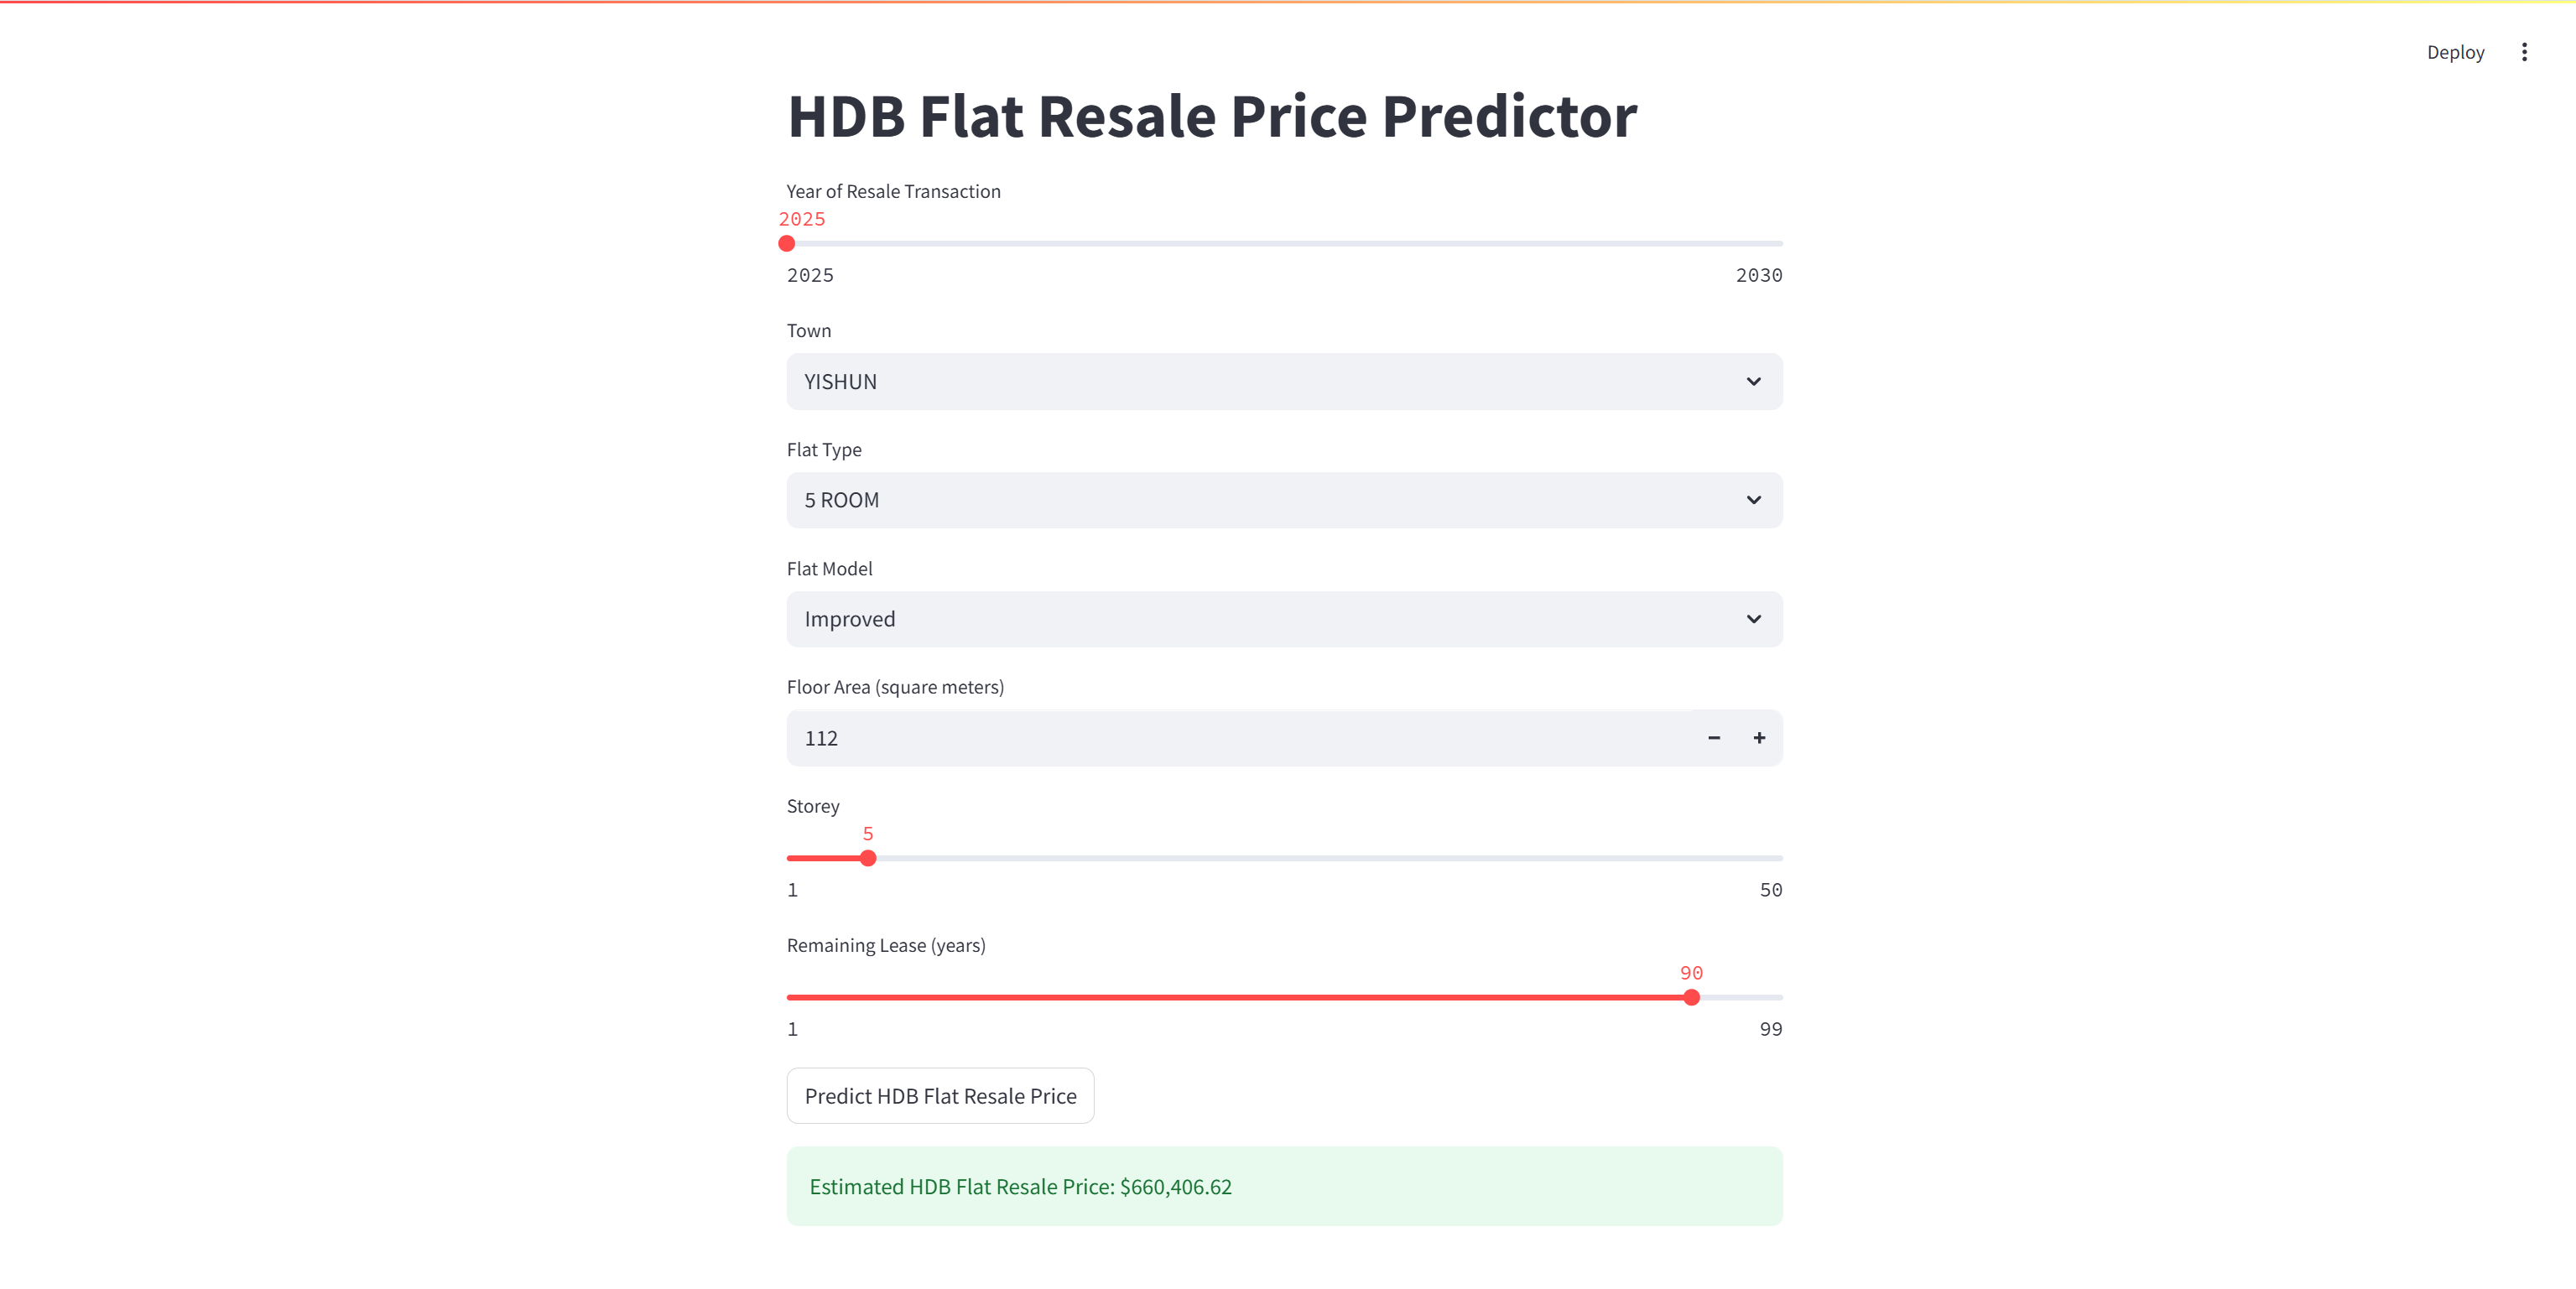